In [2]:
from uproot_io import Events, View
import numpy as np
import csv
import matplotlib
import matplotlib.pyplot as plt

In [3]:
particle_id_dict = {-2212:"ANTIPROTON", -321:"KAON -", -211:"PION -", -13:"MUON -", -11:"ELECTRON", 0:"NO BEST MATCH", 11:"POSTIRON", 13:"MUON +", 22:"GAMMA", 211:"PION +", 321:"KAON +", 2212:"PROTON", 3112:"SIGMA -", 3222:"SIGMA +"}

filename="projects\CheatedRecoFile_1.root"
events = Events(filename)

In [4]:
def particle_residuals(num_particle,dir):
    hits_x_dir = np.array([])
    hits_x = np.array([])

    if dir == "u":
        for i in range(events.reco_num_hits_u[num_particle]):
            hits_x = np.append(hits_x, events.reco_hits_u[num_particle][i])
            hits_x_dir = np.append(hits_x_dir, events.reco_hits_x_u[num_particle][i])
       
    if dir == 'v':
        for i in range(events.reco_num_hits_v[num_particle]):
            hits_x = np.append(hits_x, events.reco_hits_v[num_particle][i])
            hits_x_dir = np.append(hits_x_dir, events.reco_hits_x_v[num_particle][i])
        
    if dir == "w":
        for i in range(events.reco_num_hits_w[num_particle]):
            hits_x = np.append(hits_x, events.reco_hits_w[num_particle][i])
            hits_x_dir = np.append(hits_x_dir, events.reco_hits_x_w[num_particle][i])
   
    hits_bf = np.polyfit(hits_x,hits_x_dir,1)
    hits_x_dir_fit= [i * hits_bf[0] + hits_bf[1] for i in hits_x]
    length = ((hits_x[0]-hits_x[-1])**2 + (hits_x_dir_fit[0]-hits_x_dir_fit[-1])**2)**0.5
    residuals = np.subtract(hits_x_dir,hits_x_dir_fit)
    return residuals,length

def particle_rms_exphits(num_particle,dir,n):
    
    if dir == "u":
        nhits = events.reco_num_hits_u[num_particle]
        rms = np.std(particle_residuals(num_particle,"u")[0])

    if dir == "v":
        nhits = events.reco_num_hits_v[num_particle]
        rms = np.std(particle_residuals(num_particle,"v")[0])
    if dir == "w":
        nhits = events.reco_num_hits_w[num_particle]
        rms = np.std(particle_residuals(num_particle,"w")[0])

    return rms*(nhits**n)

def particle_rms_explen(num_particle,dir,n):
    
    if dir == "u":
        len = particle_residuals(num_particle,"u")[1]
        rms = np.std(particle_residuals(num_particle,"u")[0])

    if dir == "v":
        len = particle_residuals(num_particle,"v")[1]
        rms = np.std(particle_residuals(num_particle,"v")[0])
    if dir == "w":
        len = particle_residuals(num_particle,"w")[1]
        rms = np.std(particle_residuals(num_particle,"w")[0])

    return rms*(len**n)

def particle_sinuousity(num_particle,dir):
    path_length = 0

    if dir == "u":
        for i in range(events.reco_num_hits_u[num_particle]):
            dx = events.reco_hits_u[num_particle][i] - events.reco_hits_u[num_particle][i-1]
            dy = events.reco_hits_x_u[num_particle][i] - events.reco_hits_x_u[num_particle][i-1]
            path_length += (dx**2+dy**2)**0.5
       
    if dir == 'v':
        for i in range(events.reco_num_hits_v[num_particle]):
            dx = events.reco_hits_v[num_particle][i] - events.reco_hits_v[num_particle][i-1]
            dy = events.reco_hits_x_v[num_particle][i] - events.reco_hits_x_v[num_particle][i-1]
            path_length += (dx**2+dy**2)**0.5
    
    if dir == "w":
        for i in range(events.reco_num_hits_w[num_particle]):
            dx = events.reco_hits_w[num_particle][i] - events.reco_hits_w[num_particle][i-1]
            dy = events.reco_hits_x_w[num_particle][i] - events.reco_hits_x_w[num_particle][i-1]
            path_length += (dx**2+dy**2)**0.5
   
    length = particle_residuals(num_particle,dir)[1]
    return path_length/length
    
def pdg_idx(pdg_code,min_hits,purity):
    temp = np.where(events.mc_pdg == pdg_code)[0]
    idx = [i for i in temp if (events.reco_num_hits_w[i] >= min_hits) and (events.purity[i] >= purity)]
    return idx

def plot_hist(A,B,n_bins,z_score):
    max_A = np.mean(A)+(z_score)*np.std(A)
    max_B = np.mean(B)+(z_score)*np.std(B)
    ma = max(max_A,max_B)
    mi = min(min(A),min(B))

    if 0 < mi < 1:
        mi = 0
    bins_arr = [mi + i*((ma-mi)/n_bins) for i in range(n_bins+1)]

    plt.hist(A,range=(min(A),max_A),histtype='step',bins=bins_arr,weights=(np.ones_like(A)/np.size(A)))
    plt.hist(B,range=(min(B),max_B),histtype='step',bins=bins_arr,weights=(np.ones_like(B)/np.size(B)))
    plt.show()


In [5]:
minhits = 10

protons_idx = pdg_idx(2212,minhits,1)
pion_plus = pdg_idx(211,minhits,1)
pion_minus = pdg_idx(-211,minhits,1)
muon_plus = pdg_idx(13,minhits,1)
muon_minus = pdg_idx(-13,minhits,1) 

tracks_idx = np.concatenate((protons_idx,pion_plus,pion_minus,muon_plus,muon_minus))

electron_idx = pdg_idx(-11,minhits,1)
positron_idx = pdg_idx(11,minhits,1)
gamma_idx = pdg_idx(22,minhits,1)

showers_idx = np.concatenate((gamma_idx,positron_idx,electron_idx))


pdg = [events.mc_pdg[i] for i in range(516044) if (events.reco_num_hits_w[i] > 10) and (events.purity[i]>0.8)]
pdgs = np.unique(pdg,return_counts = True)
for i in range(np.size(pdgs[0])):
    print(pdgs[1][i], particle_id_dict[pdgs[0][i]],end = " ;")



5 ANTIPROTON ;105 KAON - ;4321 PION - ;447 MUON - ;2762 ELECTRON ;3764 POSTIRON ;3385 MUON + ;9741 GAMMA ;6688 PION + ;326 KAON + ;12893 PROTON ;1 SIGMA - ;3 SIGMA + ;

In [8]:
n_particles = 4000

tracks_idx = tracks_idx[:n_particles]
showers_idx = showers_idx[:n_particles]

tracks_metric = [particle_rms_exphits(i,"u",0) for i in tracks_idx]
showers_metric = [particle_rms_exphits(i,"u",0) for i in showers_idx]

C:\Users\red20\AppData\Local\Temp\ipykernel_17816\1426843086.py:30: RankWarning: Polyfit may be poorly conditioned
  rms = np.std(particle_residuals(num_particle,"u")[0])
C:\Users\red20\AppData\Local\Temp\ipykernel_17816\1426843086.py:30: RankWarning: Polyfit may be poorly conditioned
  rms = np.std(particle_residuals(num_particle,"u")[0])
C:\Users\red20\AppData\Local\Temp\ipykernel_17816\1426843086.py:30: RankWarning: Polyfit may be poorly conditioned
  rms = np.std(particle_residuals(num_particle,"u")[0])
C:\Users\red20\AppData\Local\Temp\ipykernel_17816\1426843086.py:30: RankWarning: Polyfit may be poorly conditioned
  rms = np.std(particle_residuals(num_particle,"u")[0])
C:\Users\red20\AppData\Local\Temp\ipykernel_17816\1426843086.py:30: RankWarning: Polyfit may be poorly conditioned
  rms = np.std(particle_residuals(num_particle,"u")[0])
C:\Users\red20\AppData\Local\Temp\ipykernel_17816\1426843086.py:30: RankWarning: Polyfit may be poorly conditioned
  rms = np.std(particle_residu

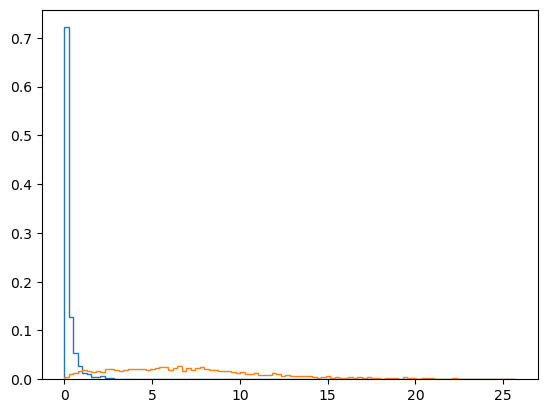

In [12]:

plot_hist(tracks_metric,showers_metric,100,3)



In [30]:
tracks_sinuousity = [particle_sinuousity(i,"w") for i in tracks_idx]
showers_sinuousity = [particle_sinuousity(i,"w") for i in showers_idx]


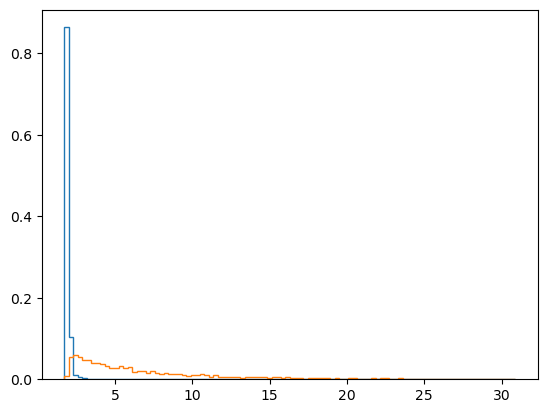

In [32]:
plot_hist(tracks_sinuousity,showers_sinuousity,100,3)

In [ ]:
#outputs arrays of efficiency and purity per divide, best_divide
def ROC_curve(tr,sh):
    max_track = max(tr)
    min_shower = min(sh)
    track = np.sort(tr)
    shower = np.sort(sh)

    track_efficiency = np.array([])
    track_purity = np.array([])
    divisions = 500
    ep_radius_max = 0

    for i in range(divisions+1):
        divide = min_shower + i*((max_track-min_shower)/divisions)
        for j in range(np.size(track)):
            if track[j] > divide:
                track_astrack = j
                track_asshower = np.size(track) - j
                break

        for j in range(np.size(shower)):
            if shower[j] > divide:
                shower_astrack = j
                shower_asshower = np.size(shower)-j
                break
        
        efficiency = (track_astrack)/(track_astrack+shower_astrack)
        purity = (track_astrack)/(track_astrack+track_asshower)

    
        ep_radius = efficiency**2 + purity**2
        if ep_radius > ep_radius_max:
            ep_radius_max = ep_radius
            best_divide = divide

        track_efficiency = np.append(track_efficiency,efficiency)
        track_purity = np.append(track_purity,purity)

    
            
    return track_efficiency, track_purity, best_divide

# outputs best divide, ep_radius_max, best_pur, best_eff
def ROC_divide(tr,sh):
    max_track = max(tr)
    min_shower = min(sh)
    track = np.sort(tr)
    shower = np.sort(sh)
    divisions = 500
    ep_radius_max = 0

    for i in range(divisions+1):
        divide = min_shower + i*((max_track-min_shower)/divisions)
        for j in range(np.size(track)):
            if track[j] > divide:
                track_astrack = j
                track_asshower = np.size(track) - j
                break

        for j in range(np.size(shower)):
            if shower[j] > divide:
                shower_astrack = j
                shower_asshower = np.size(shower)-j
                break
        
        efficiency = (track_astrack)/(track_astrack+shower_astrack)
        purity = (track_astrack)/(track_astrack+track_asshower)

    
        ep_radius = efficiency**2 + purity**2
        
        if ep_radius > ep_radius_max:
            ep_radius_max = ep_radius
            best_divide = divide
            best_eff = efficiency
            best_pur = purity
        
    return best_divide, ep_radius_max, best_pur, best_eff


1.7778661020421436
Best divide is at 0.9752481162723801


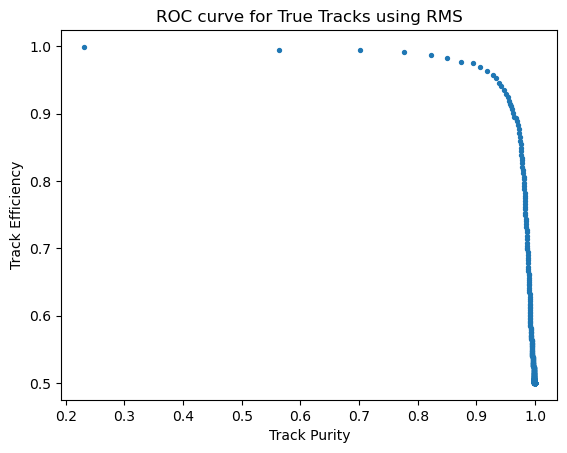

In [ ]:
eff = ROC_curve(tracks_metric,showers_sinuousity)[0]
pur = ROC_curve(tracks_metric,showers_sinuousity)[1]
divide = ROC_divide(tracks_metric,showers_sinuousity)[0]
print(ROC_divide(tracks_metric,showers_sinuousity)[1])
print("Best divide is at",divide)
plt.title("ROC curve for True Tracks using RMS")
plt.xlabel("Track Purity")
plt.ylabel("Track Efficiency")
plt.scatter(pur,eff,s = 8)

1.8281618382655807
Best divide is at 2.241799930997792


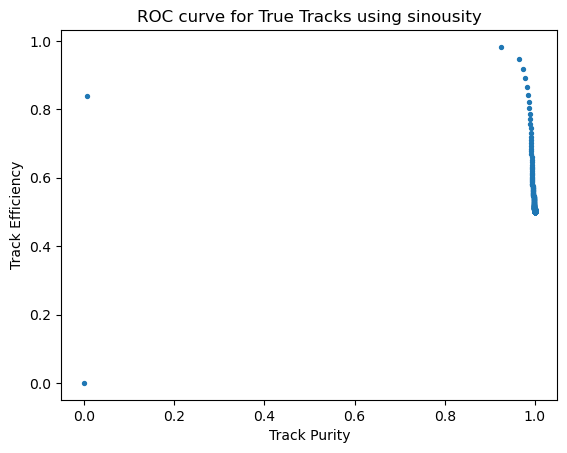

In [35]:
eff = ROC_curve(tracks_sinuousity,showers_sinuousity)[0]
pur = ROC_curve(tracks_sinuousity,showers_sinuousity)[1]
divide = ROC_divide(tracks_sinuousity,showers_sinuousity)[0]
print(ROC_divide(tracks_sinuousity,showers_sinuousity)[1])
print("Best divide is at",divide)
plt.title("ROC curve for True Tracks using sinousity")
plt.xlabel("Track Purity")
plt.ylabel("Track Efficiency")
plt.scatter(pur,eff,s = 8)

In [33]:
divide = np.array([])

for i in np.linspace(-4,2, num=13):
    tracks_nrms = [particle_rms_exphits(j,"w",i) for j in tracks_idx]
    showers_nrms = [particle_rms_exphits(j,"w",i) for j in showers_idx]
    
    ep_radius = ROC_divide(tracks_nrms,showers_nrms)[1]
    divide = np.append(divide, ep_radius)
    

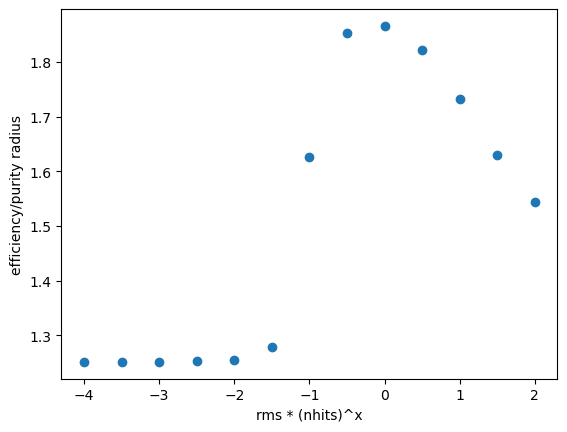

In [34]:
plt.ylabel("efficiency/purity radius")
plt.xlabel("rms * (nhits)^x")
plt.scatter(np.linspace(-4,2, num=13),divide)

In [ ]:
ep_rad = np.array([])

for i in np.linspace(-4,2, num=13):
    tracks_lenrms = [particle_rms_explen(j,"w",i) for j in tracks_idx]
    showers_lennrms = [particle_rms_explen(j,"w",i) for j in showers_idx]
    
    ep_radius = ROC_divide(tracks_lenrms,showers_lennrms)[1]
    ep_rad = np.append(ep_rad, ep_radius)

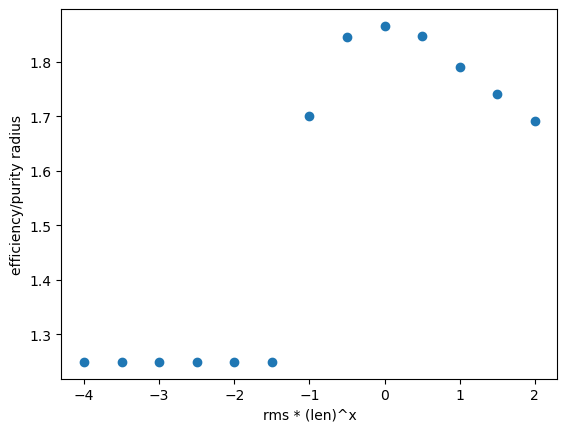

In [ ]:
plt.ylabel("efficiency/purity radius")
plt.xlabel("rms * (len)^x")
plt.scatter(np.linspace(-4,2, num=13),ep_rad)